In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [ ]:
from fastai import *
from fastai.vision import *

In [ ]:
import cv2

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = Path('drive/My Drive/')

In [ ]:
sudoku_path = path/'sudoku'
mnist_path = path/'mnist training'

In [ ]:
os.listdir(sudoku_path)

# **Image Processing**

In [ ]:
def img_scaling(img):
  scale_percent = 60 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized

In [ ]:
def process_img(proc):
  for i in range(3):
    proc = cv2.GaussianBlur(proc.copy(), (9, 9), 0)

  proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

  return proc

In [ ]:
def contour_find(dst):
  contours, hierarchy = cv2.findContours(dst,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

  contours = sorted(contours, key=cv2.contourArea, reverse=True)
  polygon = contours[0]

  bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in
   polygon]), key=operator.itemgetter(1))
  top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in
   polygon]), key=operator.itemgetter(1))
  bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in
   polygon]), key=operator.itemgetter(1))
  top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in
   polygon]), key=operator.itemgetter(1))

  lst = [polygon[top_left][0], polygon[bottom_left][0], polygon[bottom_right][0], polygon[top_right][0]]
  points = np.array(lst)

  return points

In [ ]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[0]
    rect[2] = pts[2]
    
    diff = np.diff(pts, axis = 1)
    rect[3] = pts[3]
    rect[1] = pts[1]
    
    return rect

In [ ]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([[0, 0], [0, maxHeight - 1],[maxWidth - 1, maxHeight - 1], [maxWidth - 1, 0]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [ ]:
def getCellPositions(img_PT):
    #resizing the images to take the shape of the NN model
    img_PT = cv2.resize(img_PT,(252,252))
    #computing position of each cell and storing in an array of arrays
    cell_positions = []
    
    width = img_PT.shape[1]
    height = img_PT.shape[0]
    
    cell_width = 32
    cell_height = 40

    side_border = 8
    top_border = 8
    
    x1,x2,y1,y2 = 0,0,side_border,0
    
    for i in range(9):
        y2 = y1 + cell_height 
        x1 = 0 + side_border
        for j in range(9):
            x2 = x1 + cell_width + top_border
            current_cell = [x1,x2,y1,y2]
            cell_positions.append(current_cell)
            x1 = x2 + side_border
        y1 = y2 + top_border
    return cell_positions

In [ ]:
def crop_cells(final_img):
  posns = getCellPositions(final_img)

  cropped_final = []

  for i in range(9):
    for j in range(9):
      pos = j*9 + i
      tmp_crop = final_img[posns[pos][0]:posns[pos][1], posns[pos][2]:posns[pos][3]]
      cropped_final.append(tmp_crop)
  
  return cropped_final

# **Script for Image processing**

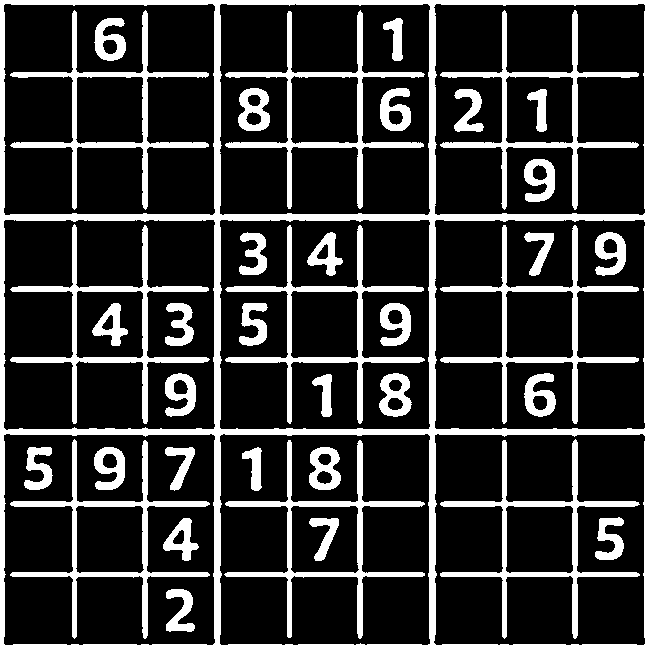

In [ ]:
name = 'dad3.jpeg'

img = cv2.imread(f'drive/My Drive/sudoku/{name}')

if img.shape[0]>640 and img.shape[1]>480:
  img = img_scaling(img)

proc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

proc = process_img(proc)

points = contour_find(proc)

final_img = four_point_transform(proc, points)
final_img = cv2.resize(final_img, (440,440))

cropped_final = crop_cells(final_img)

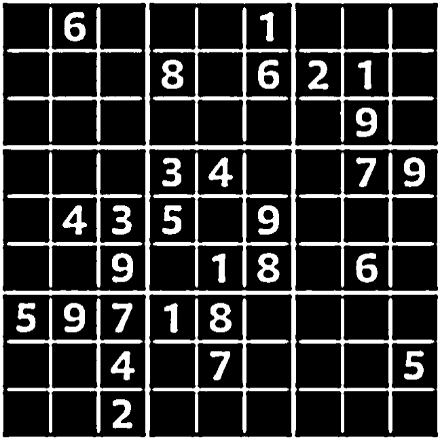

In [ ]:
cv2_imshow(final_img)

# **Digit Recognition Model**

In [ ]:
tfms = get_transforms(do_flip=False)

In [ ]:
mnist_data = (ImageList.from_folder(mnist_path) #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()          #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=28)       #Data augmentation? -> use tfms with a size of 64
        .databunch())  

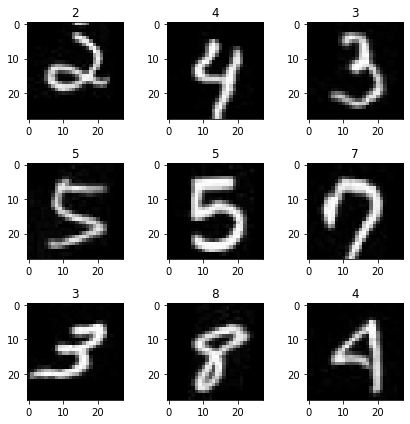

In [ ]:
mnist_data.show_batch(3, figsize=(6,6), hide_axis=False)

In [ ]:
mnist_data.classes

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'blank']

In [ ]:
learn = create_cnn(mnist_data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


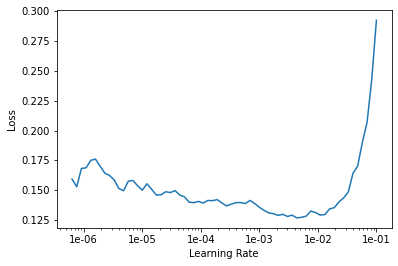

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.394792,1.771211,0.528146,00:17
1,1.693678,1.106790,0.319536,00:13
2,1.360635,0.840072,0.248344,00:13
3,1.157406,0.759672,0.226821,00:13
4,1.008161,0.737404,0.225166,00:13


In [ ]:
learn.save('stage-1')

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.905751,0.710091,0.215232,00:13
1,0.896853,0.660098,0.197020,00:13
2,0.833611,0.602497,0.192053,00:13
3,0.762174,0.560830,0.172185,00:13
4,0.720428,0.559739,0.183775,00:13


In [ ]:
learn.save('stage-2')

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.650460,0.529145,0.170530,00:13
1,0.633157,0.538347,0.163907,00:13
2,0.651100,0.560019,0.175497,00:13
3,0.667550,0.523366,0.157285,00:13
4,0.646837,0.452810,0.135762,00:13
5,0.599577,0.434989,0.127483,00:13
6,0.552339,0.385256,0.122517,00:13
7,0.518842,0.375159,0.110927,00:13
8,0.491737,0.391763,0.122517,00:13
9,0.484344,0.374017,0.107616,00:13


In [ ]:
learn.save('stage-3')

In [ ]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,time
0,0.463346,0.386194,0.125828,00:13
1,0.448687,0.370192,0.109272,00:13
2,0.448903,0.360311,0.110927,00:12
3,0.448016,0.387280,0.117550,00:13
4,0.436463,0.338058,0.097682,00:13
5,0.459173,0.337643,0.104305,00:13
6,0.446954,0.310811,0.094371,00:13
7,0.419385,0.301890,0.097682,00:13
8,0.414283,0.298548,0.094371,00:13
9,0.384744,0.276230,0.084437,00:13


In [ ]:
learn.save('stage-4')

In [ ]:
learn.fit_one_cycle(30)

epoch,train_loss,valid_loss,error_rate,time
0,0.224319,0.218703,0.069536,00:13
1,0.245522,0.215905,0.067881,00:13
2,0.241867,0.207495,0.067881,00:13
3,0.239570,0.217907,0.077815,00:13
4,0.244370,0.187456,0.067881,00:13
5,0.245022,0.193542,0.067881,00:13
6,0.252218,0.193976,0.066225,00:13
7,0.248866,0.179475,0.062914,00:13
8,0.252515,0.188999,0.067881,00:13
9,0.260168,0.216662,0.072848,00:13


In [ ]:
learn.save('stage-5')

In [ ]:
mnist_data.classes

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'blank']

In [ ]:
classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'blank']

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(15, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.281334,0.346231,0.147351,00:14
1,0.288852,0.277881,0.051325,00:13
2,0.276125,0.191421,0.056291,00:13
3,0.281469,0.764626,0.152318,00:13
4,0.283507,0.174161,0.043046,00:13
5,0.228578,0.244549,0.066225,00:13
6,0.189114,0.415062,0.087748,00:13
7,0.175920,0.338867,0.082781,00:13
8,0.147082,0.123228,0.039735,00:13
9,0.110362,0.097355,0.024834,00:13


In [ ]:
learn.save('unfrozen-1')

In [ ]:
learn.load('unfrozen-1')

# **Sudoku Grid Formation**

In [ ]:
extra_path = 'drive/My Drive/extra training digits'

In [ ]:
for i in range(81):
  cv2.imwrite(f'{extra_path}/{i}.jpg', cropped_final[i])

In [ ]:
sudoku_grid = []

for i in range(9):
  temp = []
  for j in range(9):
    img_fastai = open_image(f'{extra_path}/{i*9+j}.jpg')
    pred_class,pred_idx,outputs = learn.predict(img_fastai)
    pred = (int(pred_class) + 1) % 10
    temp.append(pred)
  sudoku_grid.append(temp)
  

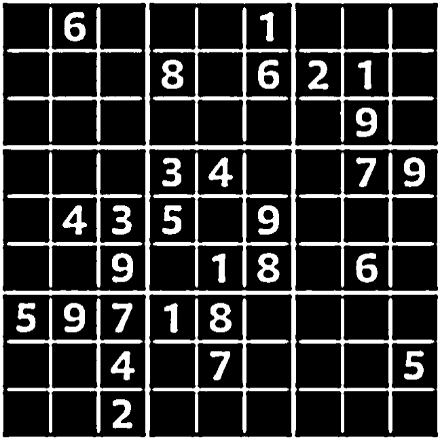

In [ ]:
cv2_imshow(final_img)

In [ ]:
sudoku_grid

[[0, 6, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 8, 0, 6, 2, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 9, 0],
 [0, 0, 0, 3, 4, 0, 0, 7, 9],
 [0, 4, 3, 5, 0, 9, 0, 0, 0],
 [0, 0, 9, 0, 1, 8, 0, 6, 0],
 [5, 9, 7, 1, 8, 0, 0, 0, 0],
 [0, 0, 4, 0, 7, 0, 0, 0, 5],
 [0, 0, 2, 0, 0, 0, 0, 0, 0]]

# **Solving the Puzzle**

In [ ]:
def solve(grid):
    find = find_empty(grid)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(grid, i, (row, col)):
            grid[row][col] = i

            if solve(grid):
                return True

            grid[row][col] = 0

    return False


def valid(grid, num, pos):
    # Check row
    for i in range(len(grid[0])):
        if grid[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(grid)):
        if grid[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if grid[i][j] == num and (i,j) != pos:
                return False

    return True

def find_empty(grid):
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if grid[i][j] == 0:
                return (i, j) 

    return None

In [ ]:
solve(sudoku_grid)

True

In [ ]:
for i in range(9):
  for j in range(9):
    print(sudoku_grid[i][j], end=" ")
  print()  

4 6 8 9 2 1 3 5 7 
9 7 5 8 3 6 2 1 4 
3 2 1 4 5 7 8 9 6 
1 8 6 3 4 2 5 7 9 
7 4 3 5 6 9 1 2 8 
2 5 9 7 1 8 4 6 3 
5 9 7 1 8 4 6 3 2 
6 1 4 2 7 3 9 8 5 
8 3 2 6 9 5 7 4 1 
